In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
from simulator import Simulator
from tools_analysis import corrcoef, coef_var
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import pandas as pd
import numpy as np
import quantities as pq
import seaborn as sns
from tools_plot import savefig, fix_figure, set_style, despine, add_caption
import copy
from IPython.display import display

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
from tqdm import tqdm_notebook as tqdm

from causal_optoconnectics.core import hit_rate

In [2]:
plt.rcParams['figure.figsize'] = (16,9)

In [3]:
from params_test import parameters
rates = np.arange(21, 40, 1.)
gs = np.arange(.5,10.5,.5)
binsize_corr = 5.
CC, CV, rates_, gs_ = [], [], [], []

pbar = tqdm(total=len(rates) * len(gs))

for rate_p in rates:
    for g in gs:
        sim = Simulator(
            parameters, fname='network_raster', data_path='results', 
            stop_time=1, stim_rate=30, stim_dist='poisson', verbose=False,
            stim_amp_ex=0, rate_p=rate_p, g=g)
        sim.simulate(state=False, save=False, raster=False, progress_bar=False)

        data = sim.data
        
        senders = sim.data['spiketrains']['ex']['senders']
        times = sim.data['spiketrains']['ex']['times']
        stim_times = sim.data['epoch']['times']
        sender_ids = np.unique(senders)
        
        idxs = np.random.randint(0, len(sender_ids), 100)

        spiketrains = [times[sender==senders] for sender in sender_ids[idxs]]
        
        t_stop = sim.p['status']['time']
        
        cc = corrcoef(
            spiketrains, t_stop, binsize=binsize_corr)
        CC.append(cc)
        
        cv = np.array(coef_var(spiketrains))
#         cv = cv[~np.isnan(cv)]
        CV.append(cv)
        rates_.append(rate_p)
        gs_.append(g)
        
        pbar.update(1)
pbar.close()

HBox(children=(IntProgress(value=0, max=380), HTML(value='')))

../tools_analysis.py:73: RuntimeWarning: invalid value encountered in true_divide
  mat = [(m - m.mean()) / m.std() for m in [a, b]]


In [4]:
data = {'CV':CV, 'CC':CC, 'rates': rates_, 'g': gs_}
np.savez('network-state.npz', data=data)

In [12]:
df_CV = pd.DataFrame()
df_CC = pd.DataFrame()
i = 0
for rate_p in rates.round(2):
    for g in gs.round(2):
        df_CV.loc[rate_p, g] = np.nanmean(CV[i])
        cc = CC[i][np.triu_indices(100, k=1)]
#         cc = cc[cc > 0]
        cc = abs(cc)
        df_CC.loc[rate_p, g] = np.nanmean(cc)
        i += 1
df_CC.rename_axis(index='rate_p', columns='g', inplace=True)
df_CV.rename_axis(index='rate_p', columns='g', inplace=True)

/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


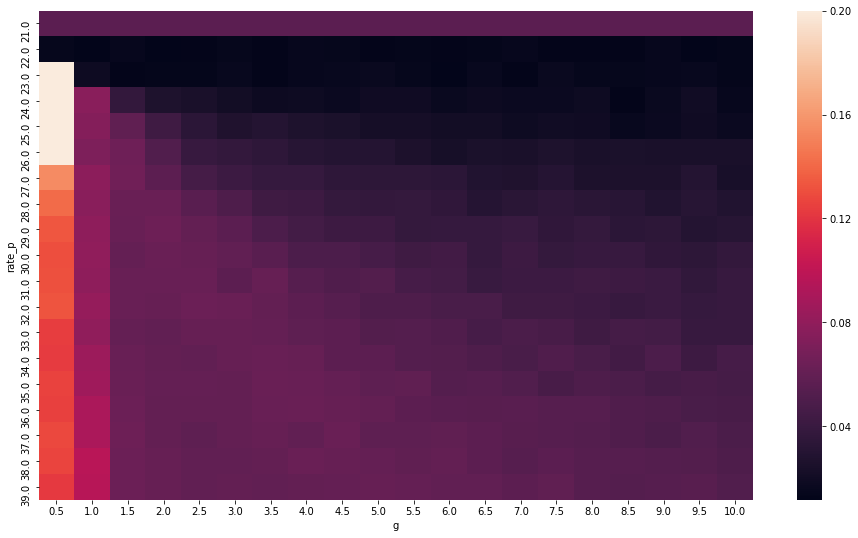

In [14]:
sns.heatmap(df_CC, vmax=.2)

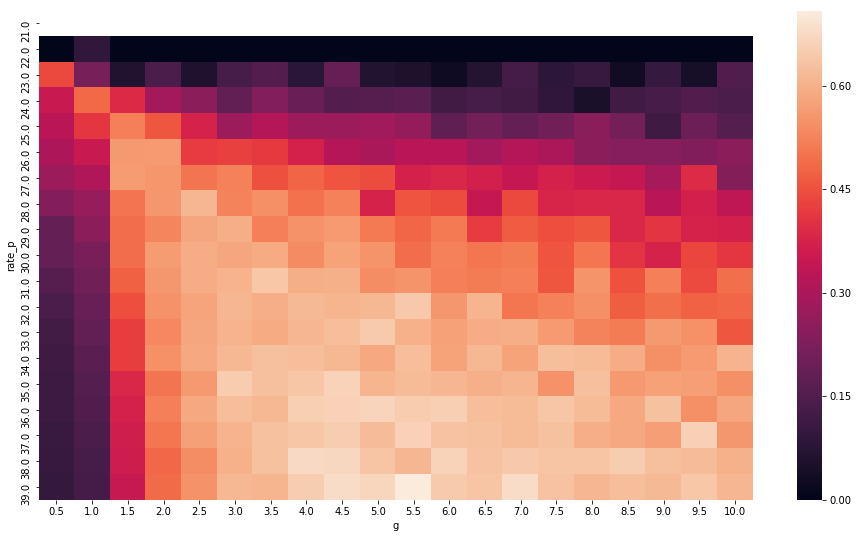

In [7]:
sns.heatmap(df_CV)

In [8]:
mat_CV = np.zeros((len(rates), len(gs))).tolist()
mat_CC = np.zeros((len(rates), len(gs))).tolist()
ii = 0
for i, rate_p in enumerate(rates):
    for j, g in enumerate(gs):
        mat_CV[i][j] = CV[ii]
        mat_CC[i][j] = CC[ii]
        ii += 1

In [17]:
idx_r, idx_g = 10, 5
rates[idx_r], gs[idx_g]

(31.0, 3.0)

Text(0.5,0,'CC')

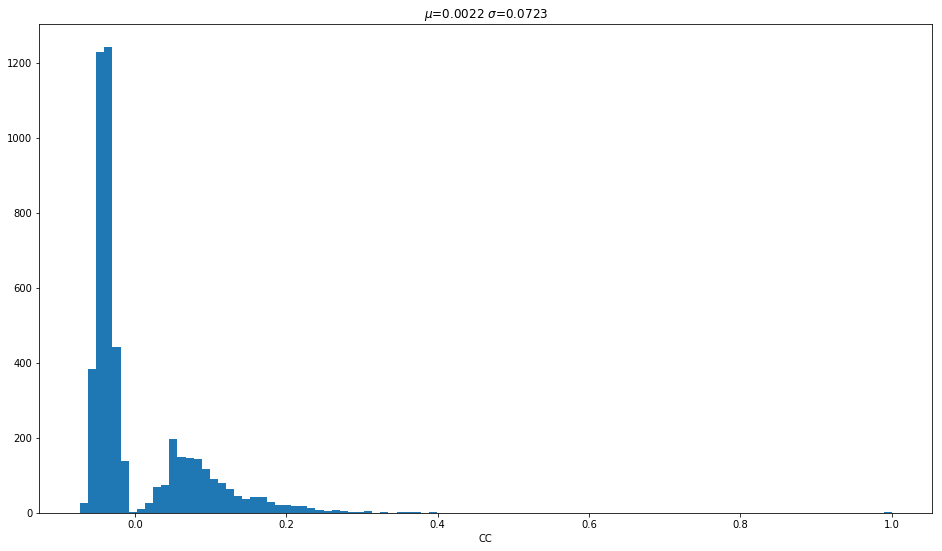

In [21]:
data_ = mat_CC[idx_r][idx_g][np.triu_indices(100, k=1)]
plt.hist(data_, bins=100);
plt.title('$\mu$={:.4f} $\sigma$={:.4f}'.format(data_.mean(), data_.std()))
plt.xlabel('CC')

ValueError: max must be larger than min in range parameter.

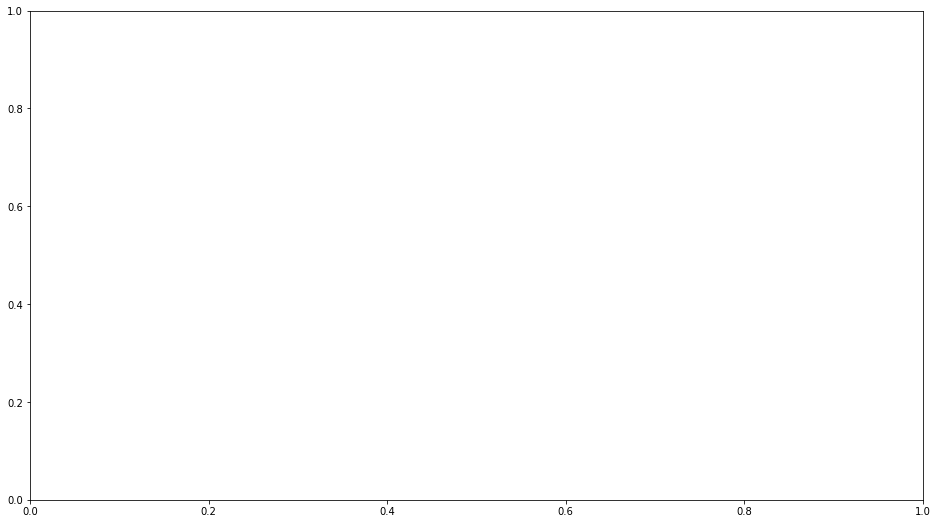

In [11]:
data_ = mat_CV[idx_r][idx_g]
plt.hist(data_, bins=100);
plt.title('$\mu$={:.4f} $\sigma$={:.4f}'.format(data_.mean(), data_.std()))